In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [31]:
import scipy as scp
import scipy.stats as ss
from scipy.optimize import minimize
from scipy import sparse
from scipy.sparse.linalg import spsolve
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.special as scsp
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator

In [32]:
#Import Data
spy = pd.read_csv('SPY.csv')
qqq = pd.read_csv('QQQ.csv')
spy_price = np.array(spy['Close'])
qqq_price = np.array(qqq['Close'])
spy_normal = (spy_price - np.mean(spy_price))/np.std(spy_price)
qqq_normal = (qqq_price - np.mean(qqq_price))/np.std(qqq_price)
actual_spread = spy_normal-qqq_normal

#Train, Test split
x = np.array(spy_price)
y = np.array(qqq_price)

In [33]:
def get_half_life(spread):  
    #Fit the training spread series to an OU process and get half-life
    dt = 1
    XX = spread[:-1]
    YY = spread[1:]
    beta, alpha, _, _, _ = ss.linregress(XX, YY)  
    kappa_ols = - np.log(beta)/dt
    theta_ols = alpha/(1-beta)
    res = YY - beta * XX - alpha                 
    std_resid = np.std(res, ddof=2)
    sig_ols = std_resid * np.sqrt(2*kappa_ols/(1-beta**2))

    return theta_ols, kappa_ols, sig_ols

In [34]:
def get_train_spread(x_train, y_train):
    #Get standard deviation for historical spread
    poly = PolynomialFeatures(degree=4, include_bias=False)
    poly_features = poly.fit_transform(x_train.reshape(-1, 1))
    clf_Lasso = linear_model.Lasso(alpha=0.05) 
    clf_Lasso.fit(poly_features, y_train)
    y_train_pred = clf_Lasso.predict(poly_features)
    pre_spread = y_train_pred - y_train
    return pre_spread

In [73]:
def get_strategy_with_risk_management(x_train, y_train, x_test, y_test, close = False):
    #Get standard deviation for historical spread
    poly = PolynomialFeatures(degree=4, include_bias=False)
    poly_features = poly.fit_transform(x_train.reshape(-1, 1))
    clf_Lasso = linear_model.Lasso(alpha=0.05) 
    clf_Lasso.fit(poly_features, y_train)
    y_train_pred = clf_Lasso.predict(poly_features)
    pre_spread = y_train_pred - y_train
    half_life = np.log(2)/get_half_life(pre_spread)[1]
    std = np.std(pre_spread)
    
    #Backtesting
    poly_features = poly.fit_transform(x_test.reshape(-1, 1))
    y_test_pred = clf_Lasso.predict(poly_features)
    #Calculate spread and z-score for testing data
    spread = y_test_pred - y_test
    z_score = spread/std

    #Get Strategy with Risk Management
    strategy = np.zeros(len(z_score))
    holding_days = 0
    for i in range(1,len(z_score)):
        #If in last trading period, exit when remaining time for trading is less than 2 half-life
        if close == True:
            if half_life <= 0 or len(z_score)-i < 2*half_life:
                strategy[i] = 0
                holding_days = 0
                return z_score, strategy
                
        if z_score[i] > 2 or (strategy[i-1] == -1 and z_score[i] > np.mean(z_score)):
            strategy[i] = -1
            holding_days += 1
            
        elif z_score[i] < -2 or (strategy[i-1] == 1 and z_score[i] < np.mean(z_score)):
            strategy[i] = 1 
            holding_days += 1
        
        else:
            holding_days = 0
            
        #If holding period is longer than 2 half-life, exit
        if holding_days > 2*half_life:
            strategy[i] = 0
            holding_days = 0
               
    return z_score, strategy

In [74]:
def get_strategy(x_train, y_train, x_test, y_test):
    #Get standard deviation for historical spread
    poly = PolynomialFeatures(degree=4, include_bias=False)
    poly_features = poly.fit_transform(x_train.reshape(-1, 1))
    clf_Lasso = linear_model.Lasso(alpha=0.05) 
    clf_Lasso.fit(poly_features, y_train)
    y_train_pred = clf_Lasso.predict(poly_features)
    pre_spread = y_train_pred - y_train
    std = np.std(pre_spread)
    
    #Backtesting
    poly_features = poly.fit_transform(x_test.reshape(-1, 1))
    y_test_pred = clf_Lasso.predict(poly_features)
    #Calculate spread and z-score for testing data
    spread = y_test_pred - y_test
    z_score = spread/std

    #Get Strategy with Risk Management
    strategy = np.zeros(len(z_score))
    for i in range(1,len(z_score)):     
        if z_score[i] > 2 or (strategy[i-1] == -1 and z_score[i] > np.mean(z_score)):
            strategy[i] = -1
            
        elif z_score[i] < -2 or (strategy[i-1] == 1 and z_score[i] < np.mean(z_score)):
            strategy[i] = 1 
               
    return z_score, strategy

In [75]:
#Calculate daily returns of the strategy
def calculate_return(strategy, x_test, y_test):
    returns = []
    short = False
    long = False

    for i in range(len(strategy)):
        #Case1: Open Short Position
        if strategy[i] == -1 and not short:
            returns.append(0)
            short = True
          
        #Case2: Open Long Position
        elif strategy[i] == 1 and not long:
            returns.append(0)
            long = True
    
        #Case3: Holding Short Position
        elif short:
            daily_return = 0.5*((x_test[i-1]-x_test[i])/x_test[i]) + 0.5*((y_test[i]-y_test[i-1])/y_test[i-1])
            returns.append(daily_return)
            #Exit
            if strategy[i] == 0:
                short = False
            else:
                continue
    
        #Case4: Holding Long Position
        elif long:
            daily_return = 0.5*((y_test[i-1]-y_test[i])/y_test[i]) + 0.5*((x_test[i]-x_test[i-1])/x_test[i-1])
            returns.append(daily_return)
            #Exit
            if strategy[i] == 0:
                long = False
            else:
                continue
            
        else:
            returns.append(0)
        
    return returns

In [77]:
all_returns = []
all_spread = []
for i in range((len(x)-63)//21):
    x_train, x_test = x[21*i:21*(i+3)], x[21*(i+3):21*(i+4)]
    y_train, y_test = y[21*i:21*(i+3)], y[21*(i+3):21*(i+4)]   
    temp_spread, strategy = get_strategy_with_risk_management(x_train, y_train, x_test, y_test)
    temp_returns = calculate_return(strategy, x_test, y_test)
    all_spread.extend(temp_spread)
    all_returns.extend(temp_returns)

#Last Period
x_train, x_remain = x[21*(i+1):21*(i+4)], x[21*(i+4):]
y_train, y_remain = y[21*(i+1):21*(i+4)], y[21*(i+4):]
temp_spread, strategy = get_strategy_with_risk_management(x_train, y_train, x_remain, y_remain, True)
temp_returns = calculate_return(strategy, x_remain, y_remain)
all_returns.extend(temp_returns)
all_spread.extend(temp_spread)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2087080888093333, tolerance: 0.01859695691315454
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2698324724553447, tolerance: 0.03340624472331068
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.707679669028201, tolerance: 0.0164634782919439
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Convergenc

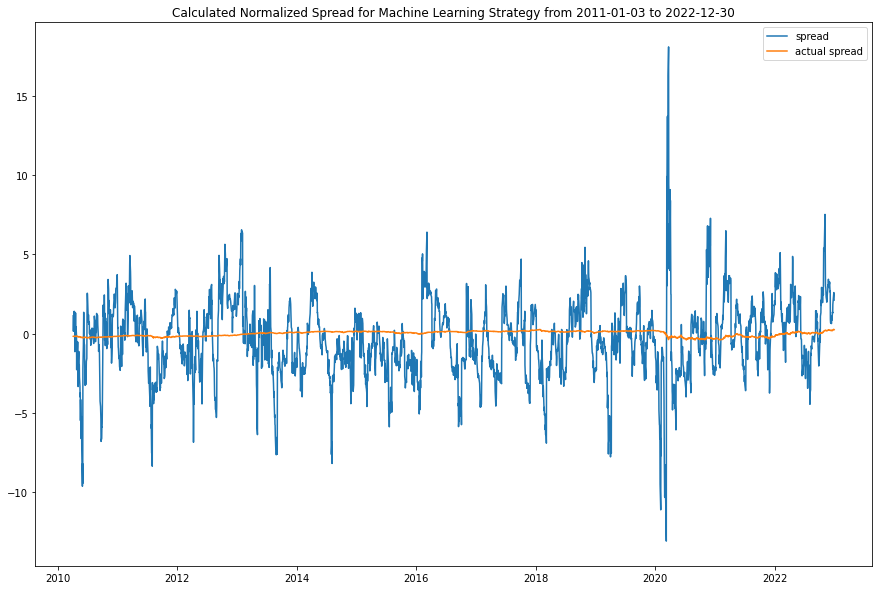

In [78]:
dates = np.asarray(spy['Date'][63:], dtype='datetime64[s]')
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(dates, all_spread, label = 'spread')
plt.plot(dates, actual_spread[63:], label = 'actual spread')
plt.title('Calculated Normalized Spread for Machine Learning Strategy from 2011-01-03 to 2022-12-30')
plt.legend()

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2010-04-06
End date,2022-12-30
Total months,152
,Backtest
Annual return,2.3%
Cumulative returns,34.3%
Annual volatility,2.5%
Sharpe ratio,0.95
Calmar ratio,0.47
Stability,0.94
Max drawdown,-5.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.96,2022-01-03,2022-11-03,NaT,NaN
1,3.41,2012-09-21,2013-10-02,2015-03-25,654
2,3.20,2017-01-09,2018-03-12,2018-09-18,442
3,1.92,2021-02-03,2021-03-05,2021-04-01,42
4,1.78,2020-04-13,2020-05-15,2020-06-05,40


/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/timeseries.py:1228: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future vers

Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.04%,-0.26%,0.43%
EZB IR Event,-0.03%,-0.30%,0.22%
Flash Crash,0.13%,0.00%,0.53%
Apr14,-0.00%,-0.73%,0.55%
Oct14,0.05%,-0.17%,0.71%
Fall2015,0.02%,-0.23%,0.41%
Recovery,0.01%,-0.59%,1.00%
New Normal,0.01%,-0.82%,1.27%


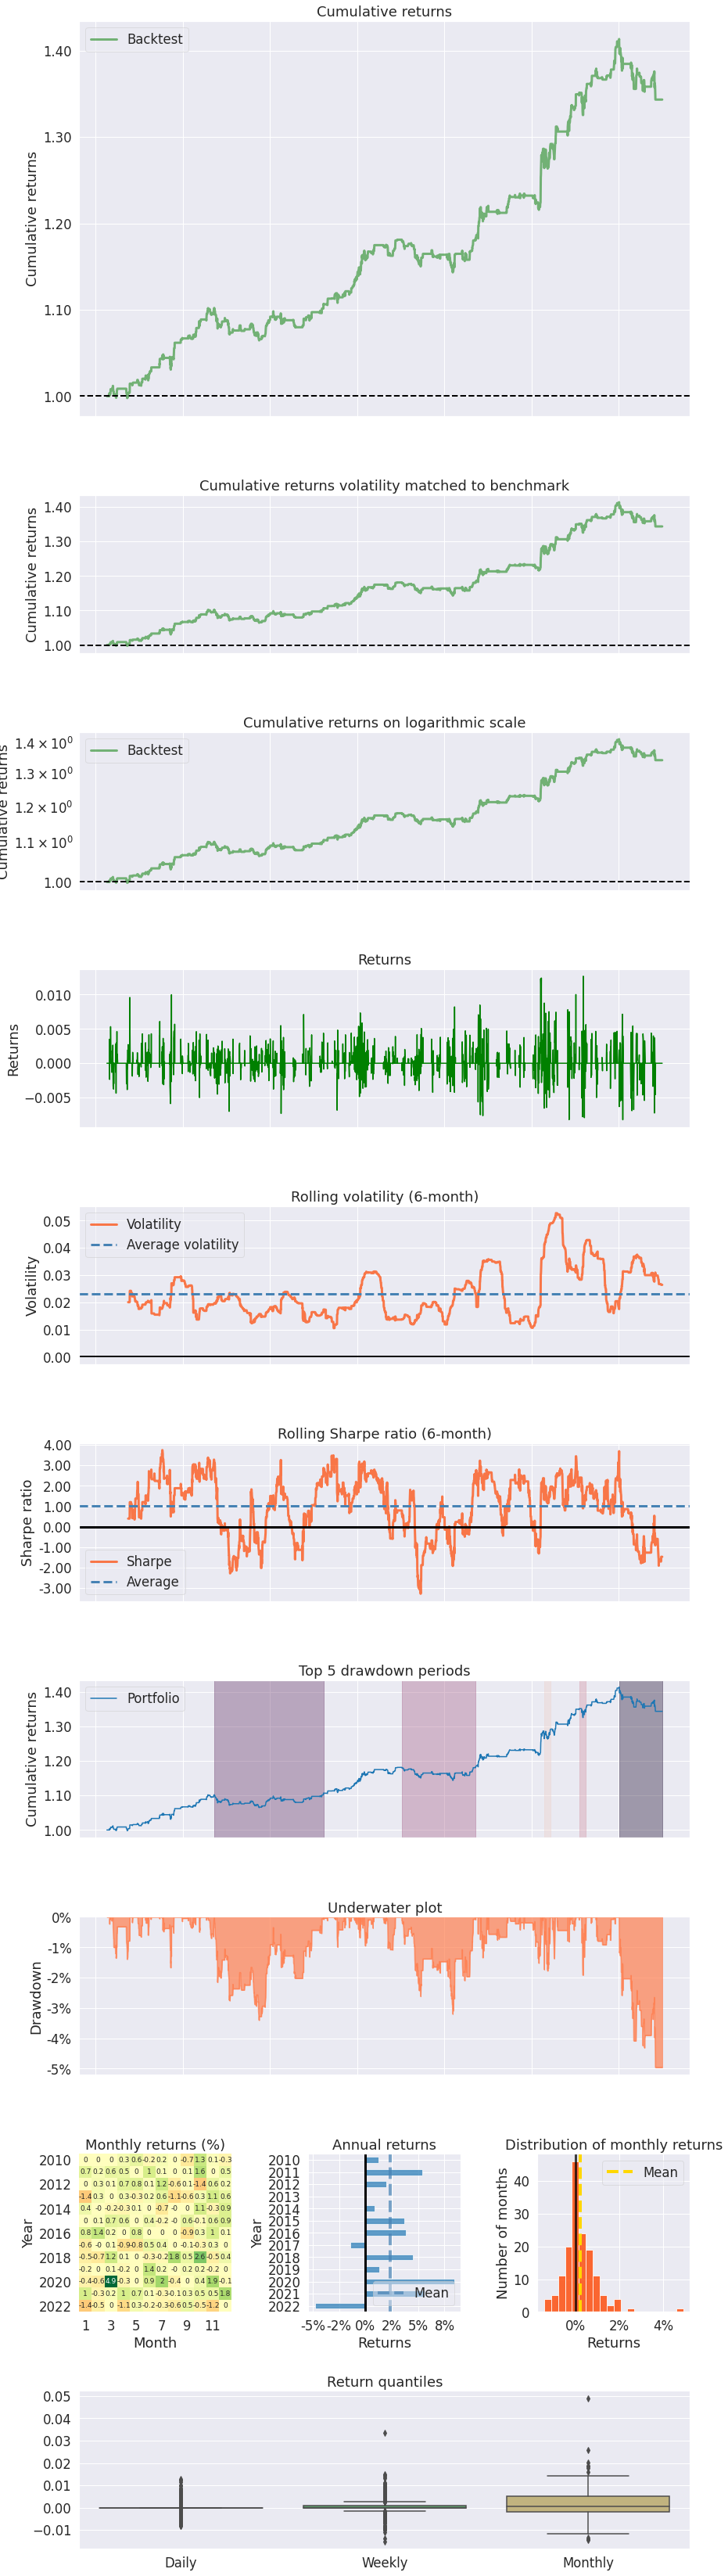

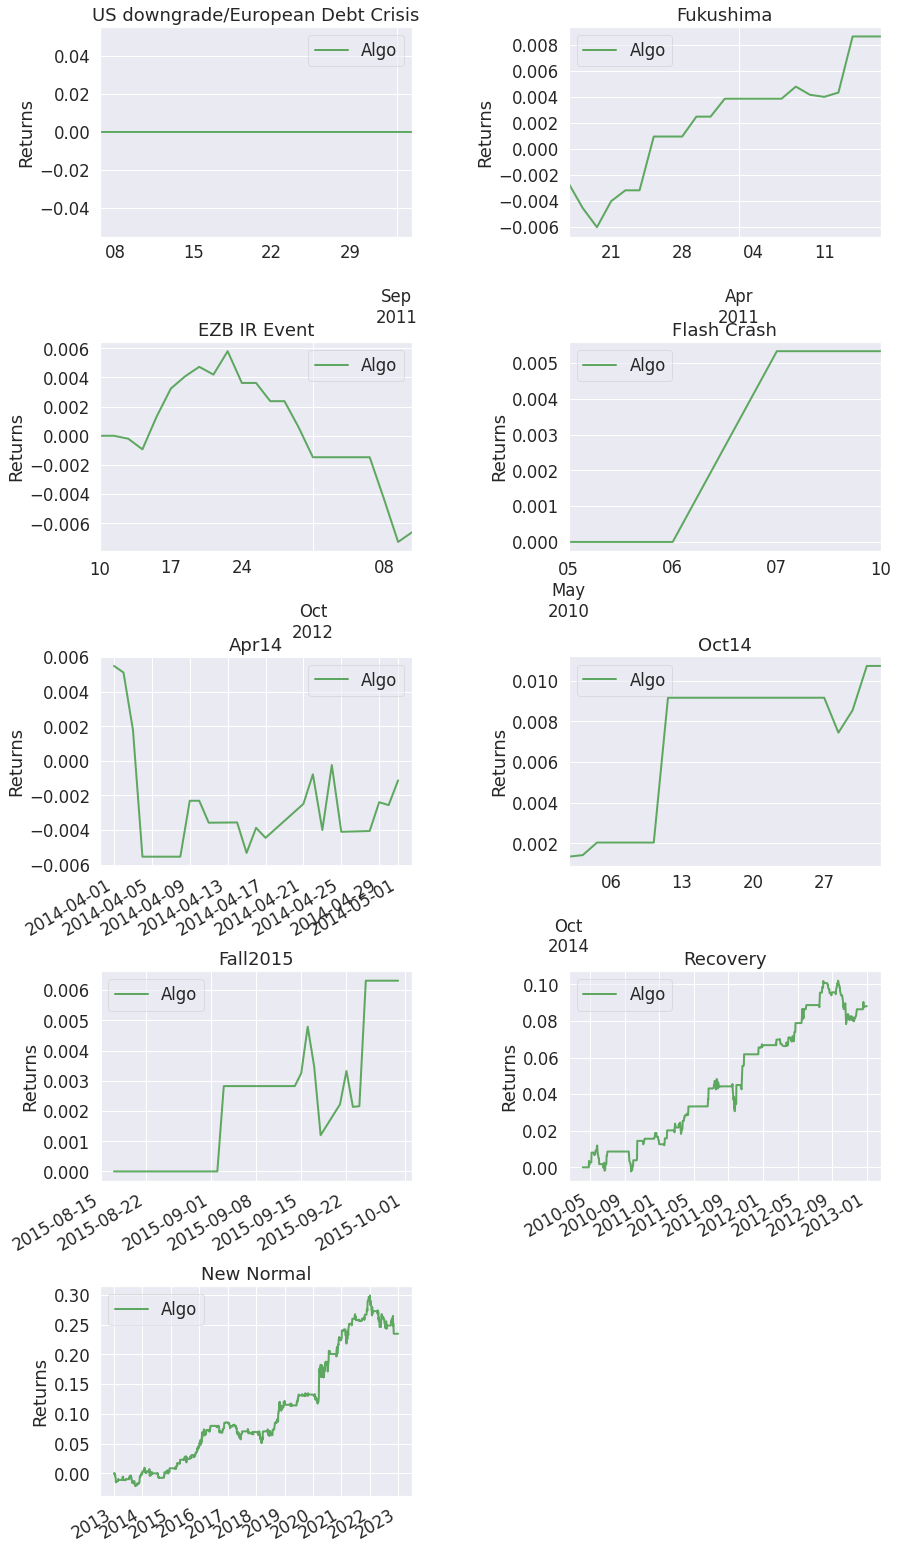

In [79]:
#Backtesting Visualization
import pyfolio as pf
from datetime import datetime
dates = pd.to_datetime(spy['Date'][63:])
rets = pd.Series(data = all_returns, index = dates)
rets = rets.tz_localize('UTC')
pf.create_full_tear_sheet(returns=rets)